<div style="text-align:center; color:#3498db; font-size:32px; font-weight:bold;">Telco Customer Churn Analysis and Prediction</div> <br>

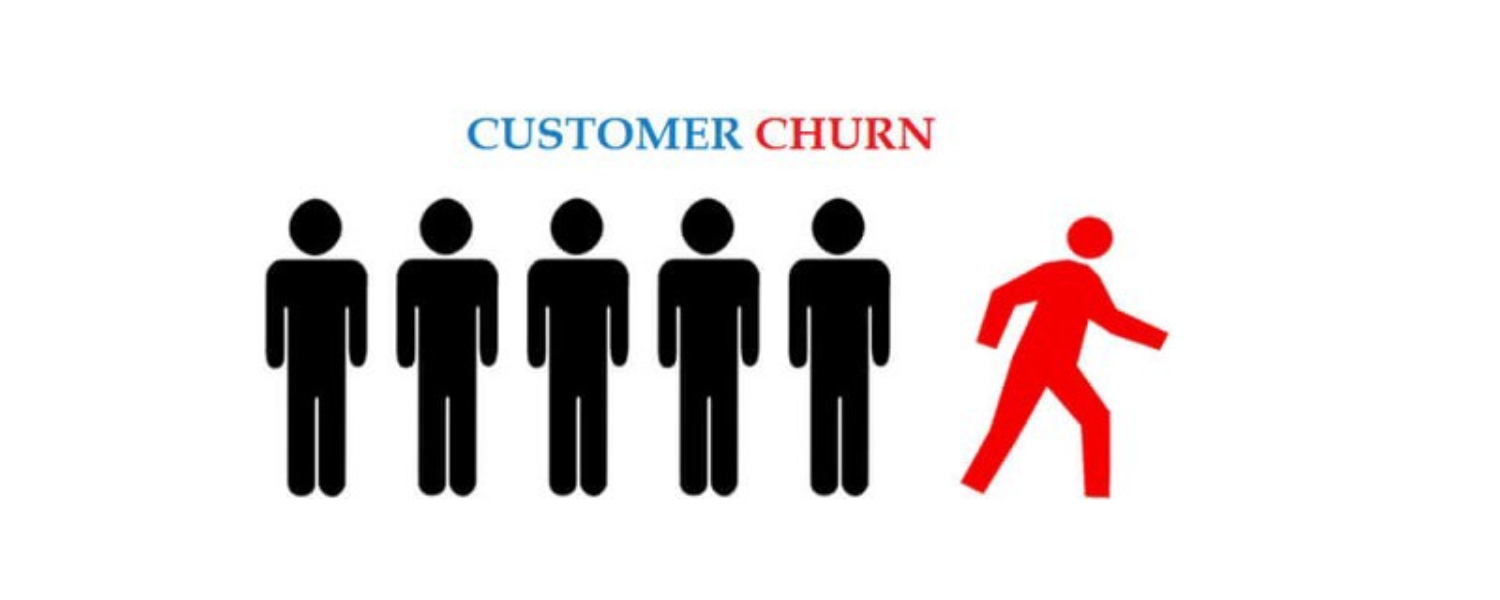

# Content

1. [Introduction](#introduction)
   - [The problem](#the-problem)
   - [The goal](#the-goal)
   - [Objectives](#objectives)
2. [Import Libraries and Data](#import-libraries-and-data)
3. [EDA (Exploratory Data Analysis)](#eda-exploratory-data-analysis)
   - [Understand the data](#understand-the-data)
   - [Manipulate the data](#manipulate-the-data)
   - [Visualize the data](#visualize-the-data)
   - [Insights](#insights)
4. [Feature Engineering](#feature-engineering)
   - [Encode categorical features](#encode-categorical-features)
   - [Scale numerical features](#scale-numerical-features)
   - [Handle imbalanced data](#handle-imbalanced-data)
5. [Model Selection](#model-selection)
    - [Models creation and cross validation](#models-creation-and-cross-validation)
    - [Best models evaluation](#best-models-evaluation)
6. [Fine-Tune Best Models](#fine-tune-best-models)
7. [Conclusion](#conclusion)
   - [Data insights](#data-insights)
   - [Model choice](#model-choice)
   - [What's next](#whats-next)


# 1. Introduction <a id="introduction"></a>

### The Problem <a id="the-problem"></a>
Customer churn is a critical concern for a telecommunications company due to its direct impact on revenue, high customer acquisition costs, and potential erosion of market share. Additionally, it affects the company's brand image, long-term customer value, and ability to leverage customer data for upselling efforts. Addressing churn is paramount for financial stability, market competitiveness, and sustaining investor confidence.

### The Goal <a id="the-goal"></a>
The goal of this project is to develop a predictive model that anticipates customer churn in a telecommunications company. By leveraging advanced analytics and machine learning, we aim to proactively identify at-risk customers, allowing us to implement targeted retention strategies and ultimately reduce churn rates.

### The Objectives <a id="objectives"></a>
- Uncover valuable information from the provided dataset.
- Determine the factors that may lead a customer to churn.
- Develop a classification model to forecast customer churn.
- Fine-tune the model to enhance its predictive accuracy.

# 2. Import libraries and data <a id="import-libraries-and-data"></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import missingno as msno

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.pipeline import Pipeline as Pipeline_imb

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import  recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, make_scorer

from sklearn.model_selection import cross_validate, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
filepath = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(filepath)

In [ ]:
df.head()

# 3. EDA (Exploratory Data Analysis) <a id="eda-exploratory-data-analysis"/>

### Understand the data  <a id="understand-the-data"/>

In [ ]:
df.info()

In [ ]:
num_features = df.select_dtypes(include=np.number).columns
cat_features = df.select_dtypes(include=object).columns

In [ ]:
for feature in num_features: 
    sns.histplot(data=df, x=feature, kde=True)
    plt.title("Histogram of {} with KDE".format(feature))
    plt.tight_layout()
    plt.show()
    
df[num_features].describe().T

In [ ]:
table = []
for feature in cat_features:
    data = df[feature]
    table.append([data.name, data.nunique(), data.unique()])
print(tabulate(table, headers=["Feature", "Num. of Categories", "Categories"], tablefmt="pretty"))

In [ ]:
msno.matrix(df)

for feature in df.columns:
    percentage_missing = df[feature].isnull().sum()/df.shape[0]*100
    if percentage_missing > 0:
        percentage_formatted = "{:.3f}".format(percentage_missing)
        print (f'{feature}: {percentage_formatted}%')

In [ ]:
df.duplicated().sum()

- The dataset contains no missing nor duplicated values.
- SeniorCitizen is actually a categorical feature.
- TotalCharges should be a numerical feature.

### Manipulate the data <a id="manipulate-the-data"/>

In [ ]:
df.drop('customerID',axis=1,inplace=True)
df['CAT_SeniorCitizen'] = df['SeniorCitizen'].map({0:'No',1:'Yes'})
df['NUM_TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
print('SenionCitizen nulls created:', df['CAT_SeniorCitizen'].isnull().sum())
print('TotalCharges nulls created:',df['NUM_TotalCharges'].isnull().sum())

In [ ]:
df.loc[df['NUM_TotalCharges'].isnull()]

In [ ]:
df[df['tenure']==0].index

As we can see totalCharges are null where tenure is 0. Let's make totalCharges include the next charge that the user will pay in the future.

In [ ]:
df['NUM_TotalCharges'].fillna(0,inplace=True)
df['TotalCharges']=df['NUM_TotalCharges']+df['MonthlyCharges']
df['SeniorCitizen']=df['CAT_SeniorCitizen']
df.drop(['NUM_TotalCharges','CAT_SeniorCitizen'],axis=1,inplace=True)

In [ ]:
df.duplicated().sum()

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
def count_outliers(feature):
    data = df[feature]
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    # Define lower and upper cutoff for outliers
    lower_cutoff = Q1 - 1.5 * IQR
    upper_cutoff = Q3 + 1.5 * IQR
    # Identify outliers
    outliers = [value for value in data if value < lower_cutoff or value > upper_cutoff]
    
    return len(outliers)

In [ ]:
num_features = df.select_dtypes(include=np.number).columns
cat_features = df.select_dtypes(include=object).columns

for feature in num_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x=feature)
    plt.title("Boxplot of {}".format(feature))
    plt.tight_layout()
    plt.show()
    
    outliers=count_outliers(feature)
    print(f'{feature} outliers detected: {outliers}')

### Visualization of the data <a id="visualize-the-data">

In [ ]:
def plot_pie_chart(feature):
    labels = df[feature].unique()
    values = df[feature].value_counts()
    
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False,
                                      wedgeprops=dict(width=0.6))
    center_circle = plt.Circle((0, 0), 0.3, color='white')
    fig.gca().add_artist(center_circle)
    
    ax.set_title(f'{feature} Distribution')
    ax.axis('equal')
    plt.show()

def plot_grouped_bar(feature, default='Churn'):
    data = df.groupby([feature, default]).size().reset_index(name='Count')
    sns.catplot(data=data, kind="bar", x=feature, y="Count", hue=default, errorbar=None, alpha=.6, height=6)
    plt.title(f'{feature} regarding {default}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()
    
def plot_stacked_bar(feature, default='Churn'):
    df.groupby([feature, default]).size().unstack().plot(kind='bar', stacked=True)
    plt.title(f'{feature} regarding {default}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def plot_kde(feature):
    ax = sns.kdeplot(data=df, x=feature, hue='Churn', hue_order=['No', 'Yes'], multiple='stack')
    ax.set_ylabel('Count')
    ax.set_xlabel(feature)
    ax.set_title(f'Distribution of {feature} regarding churn')
    plt.show()

In [ ]:
plot_pie_chart('Churn')

This dataset is imbalanced.

In [ ]:
for feature in cat_features[:-1]:
    if df[feature].nunique()<3:
        plot_grouped_bar(feature)
    else:
        plot_stacked_bar(feature)

In [ ]:
for feature in num_features:
    plot_kde(feature)

### Insights <a id="insights"></a>
- The data shows an imbalance.
- Senior citizens have a churn rate of nearly 50%.
- Although Fiber optic is preferred, almost half of its users end up churning.
- Approximately half of the customers without OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport services experience churn.
- The presence or absence of Streaming Services doesn't significantly affect churn; about one-third of customers churn regardless.
- While the majority opt for month-to-month contracts, almost 50% of them exhibit a tendency to churn. - One or two-year contracts are notably more reliable.
- A large portion of customers, around one-third, who use PaperlessBill experience churn.
- Despite a preference for electronic check payments, about half of the customers who choose this method end up churning. Automatic transfers show better results than checks.
- A significant number of customers tend to churn in the early months of their tenure.
- Customers with higher MonthlyCharges are more likely to churn.
- Customers who have paid higher TotalCharges show a lower likelihood of churning.

# 4. Feature Engineering <a id="feature-engineering">

In [ ]:
SEED = 42

In [ ]:
# Convert target feature to 0,1
df['Churn']=df['Churn'].map({'No':0,'Yes':1})

In [ ]:
# Split the data
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.30, random_state = SEED)

In [ ]:
print("Train set shapes:", X_train.shape, y_train.shape)
print("Test set shapes:", X_test.shape, y_test.shape)

### Encode categorical features <a id="encode-categorical-features">

In [ ]:
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
      'PhoneService', 'MultipleLines', 'InternetService', 
      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
      'TechSupport', 'StreamingTV', 'StreamingMovies', 
      'Contract', 'PaperlessBilling', 'PaymentMethod']

In [ ]:
# One Hot Encoder
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
data = encoder.fit_transform(X_train[cat_cols])
feature_names = encoder.get_feature_names_out()

In [ ]:
print('Number of categorical columns before OHE:', len(cat_cols))
print('Number of categorical columns after OHE:', len(feature_names))

### Scale numerical features <a id="scale-numerical-features">

In [ ]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:
def plot_before_after_scale(normal, scaled, feature, scaler_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    
    plt.sca(axes[0])
    sns.kdeplot(normal[feature], color='#008080', fill= True, alpha=.7, linewidth=0)
    axes[0].set(title = "Before scaling")
    axes[0].set_xlabel(feature)

    plt.sca(axes[1])
    sns.kdeplot(scaled[feature], color='#FF6347', fill= True, alpha=.7, linewidth=0)
    axes[1].set(title = f"After scaling using {scaler_name}")
    axes[1].set_xlabel(feature)

    plt.tight_layout()
    plt.show()

In [ ]:
### Standard Scaler
scaler = StandardScaler()
data = scaler.fit_transform(X_train[num_cols])
scaled_df = pd.DataFrame(data, columns=num_cols)
for feature in num_cols:
    plot_before_after_scale(X_train, scaled_df, feature, 'StandardScaler')

In [ ]:
### Create a transformer
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
    (StandardScaler(), num_features),
    remainder='passthrough'
)

In [ ]:
### Transform
transformed = transformer.fit_transform(X_train)
### Create the transformed dataset
transformed_X_train = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
transformed_X_train.head()

### Handle imbalanced data <a id="handle-imbalanced-data">

In [ ]:
resamping = SMOTE(random_state=SEED)
_, y_train_res = resamping.fit_resample(transformed_X_train, y_train)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting pie chart for original data
axes[0].pie([sum(y_train == 0), sum(y_train == 1)], labels=[0, 1], autopct='%1.1f%%')
axes[0].set_title("Original Data")

# Plotting pie chart for resampled data
axes[1].pie([sum(y_train_res == 0), sum(y_train_res == 1)], labels=[0, 1], autopct='%1.1f%%')
axes[1].set_title(f"Resampled Data using SMOTE")

plt.tight_layout()
plt.show()

print(f"Before SMOTE:")
print("Class 0:", sum(y_train == 0))
print("Class 1:", sum(y_train == 1))

print(f"\nAfter SMOTE:")
print("Class 0:", sum(y_train_res == 0))
print("Class 1:", sum(y_train_res == 1))

# 5. Model Selection <a id="model-selection">

We will prioritize models that strike a balanced performance between recall and precision. However, our primary focus will be on maximizing recall, as accurately identifying customers who are likely to churn is of greater importance to us than potentially misclassifying a customer as churned.

### Models creation and cross validation <a id="models-cross-validation">

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=SEED),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'AdaBoost': AdaBoostClassifier(random_state=SEED),
    'Gradient Boosting': GradientBoostingClassifier(random_state=SEED),
}

scoring = {
    'f1': make_scorer(f1_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'accuracy': make_scorer(accuracy_score)
}

scoreboard=pd.DataFrame(columns=[
    'Model', 'Resample', 
    'Avg F1', 'Avg Recall',
    'Avg Precision', 'Accuracy'
])
# scoreboard.drop(scoreboard.index,inplace=True)

In [ ]:
def get_model_cross_val(pipeline, X, y, metrics):
    cv_results = cross_validate(pipeline, X, y, scoring = metrics)
    
    f1_score = cv_results['test_f1'].mean()
    recall_score = cv_results['test_recall'].mean()
    precision_score = cv_results['test_precision'].mean()
    accuracy_score = cv_results['test_accuracy'].mean()
    
    model_name= pipeline.named_steps['model'].__class__.__name__
    res_name= 'None' if isinstance(pipeline.named_steps['resample'], type(None)) \
                        else pipeline.named_steps['resample'].__class__.__name__

        
    data = [(model_name,res_name, precision_score, recall_score, f1_score, accuracy_score)]
    model_scores = pd.DataFrame(data = data, columns=['Model','Resample', 'Avg Precision', 'Avg Recall',
                                                         'Avg F1', 'Accuracy'])
    
    return model_scores

In [ ]:
original_data_scoreboard = scoreboard.copy()
for model in models.values():
    pipeline = Pipeline_imb([
        ('transformer', transformer),
        ('resample', None),
        ('model', model)
    ])
    model_scores = get_model_cross_val(pipeline, X_train, y_train, scoring)
    original_data_scoreboard = pd.concat([original_data_scoreboard, model_scores], ignore_index=True)

In [ ]:
original_data_scoreboard.style.background_gradient(cmap='coolwarm')

Upon validation, it appears that Logistic Regression, Adaboost Classifier, and Gradient Boosting Classifier demonstrate the most promising results using the original dataset, aligning well with our specific criteria and objectives.

In [ ]:
upsampled_data_scoreboard = scoreboard.copy()
for model in models.values():
    pipeline = Pipeline_imb([
        ('transformer', transformer),
        ('resample', SMOTE(random_state=SEED)),
        ('model', model)
    ])
    model_scores = get_model_cross_val(pipeline, X_train, y_train, scoring)
    upsampled_data_scoreboard = pd.concat([upsampled_data_scoreboard, model_scores], ignore_index=True)

In [ ]:
upsampled_data_scoreboard.style.background_gradient(cmap='coolwarm')

The upsampled data has led to enhancements in the performance of the models under consideration. While there may have been a slight reduction in precision, the gains in recall and F1 score are notable. 

In [ ]:
final_scoreboard = pd.concat([original_data_scoreboard, upsampled_data_scoreboard], 
                             ignore_index=True)
final_scoreboard.sort_values(by="Avg Recall",
                   ascending=False).style.background_gradient(cmap='coolwarm')

After evaluating both the original and upsampled data, we have decided to focus on fine-tuning the Logistic Regression and Adaboost Classifier models due to their impressive performance metrics, including high precision and good F1 scores. While Logistic Regression may exhibit lower precision, it excels in recall.

We've decided not to pursue further tuning for the Gradient Boosting Classifier, even though it performed well, since our main focus is on maximizing recall.

### Best models evaluation <a id="best-models-evaluation">

In [5]:
def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    model_name= pipeline.named_steps['model'].__class__.__name__
    res_name= 'None' if isinstance(pipeline.named_steps['resample'], type(None)) \
                        else pipeline.named_steps['resample'].__class__.__name__
    
    cm = confusion_matrix(y_test,y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred)
    
    print(f'{model_name}:')
    print('==============================')
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    
    plt.sca(axes[0])
    plot_confusion_matrix(cm)
    
    plt.sca(axes[1])
    plot_roc_curve(y_pred_prob, fpr, tpr, thresholds)
    
    plt.tight_layout()
    plt.show()
    
    print(report)
    
def plot_confusion_matrix(cm):
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    
def plot_roc_curve(y_pred_prob, fpr, tpr, thresholds):
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color="r")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=16)

In [6]:
pipeline = Pipeline_imb([
        ('transformer', transformer),
        ('resample', SMOTE(random_state=SEED)),
        ('model', LogisticRegression(random_state=SEED))
    ])
pipeline.fit(X_train,y_train)
model_evaluation(pipeline, X_test, y_test)

NameError: name 'transformer' is not defined

In [ ]:
pipeline = Pipeline_imb([
        ('transformer', transformer),
        ('resample', SMOTE(random_state=SEED)),
        ('model', AdaBoostClassifier(random_state=SEED))
    ])
pipeline.fit(X_train,y_train)
model_evaluation(pipeline, X_test, y_test)

Both models demonstrated good performance during evaluation. The AdaBoostClassifier slightly outperformed in terms of F1 score, while the LogisticRegression showed a slightly higher recall.

# 6. Fine-Tune Best Models <a id="fine-tune-best-models">

We aim for a balanced trade-off between recall and precision in our models. Therefore, we will employ the F1-score as the scoring metric in our grid search. Prioritizing recall over precision could lead to a significant reduction in precision, which is not desirable for our specific objectives.

In [ ]:
pipeline = Pipeline_imb([
    ('transformer',transformer),
    ('resample',SMOTE(random_state=SEED)),
    ('model', LogisticRegression(random_state=SEED))
])

params = {
    'model__penalty': ['l1','l2'],
    'model__C': [0.01, 0.1, 1.0, 10.0], 
    'model__solver':['lbfgs','liblinear','saga'],
    'model__max_iter':[*range(100,1100,100)]
}

gscv = GridSearchCV(estimator=pipeline, param_grid=params, 
                      scoring='f1', n_jobs=-1)
gscv.fit(X, y);

In [ ]:
best_params = gscv.best_params_
print('Logistic Regression best params:\n', best_params)
#{'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

In [ ]:
best_model = gscv.best_estimator_
model_evaluation(best_model, X_test,y_test)

In [ ]:
pipeline = Pipeline_imb([
    ('transformer',transformer),
    ('resample',SMOTE(random_state=SEED)),
    ('model', AdaBoostClassifier(random_state=SEED))
])

params = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__estimator': [DecisionTreeClassifier(max_depth=1)],
    'model__estimator__max_depth': [1, 2, 3],
    'model__estimator__min_samples_split': [2, 5, 10],
    'model__estimator__min_samples_leaf': [1, 2, 4],
}

gscv = GridSearchCV(estimator=pipeline, param_grid=params, 
                      scoring='f1', n_jobs=-1)
gscv.fit(X, y);

In [ ]:
best_params = gscv.best_params_
print('AdaBoost Classifier best params:\n', best_params)
# {'model__estimator': DecisionTreeClassifier(max_depth=1), 'model__estimator__max_depth': 1, 'model__estimator__min_samples_leaf': 1, 'model__estimator__min_samples_split': 2, 'model__learning_rate': 0.1, 'model__n_estimators': 200}

In [ ]:
best_model = gscv.best_estimator_
model_evaluation(best_model, X_test,y_test)

Both optimized models perform well in terms of recall. The Logistic Regression model correctly classifies one additional customer in the test data compared to the other tuned model.

# 7. Conclusion <a id="conclusion">

### Data insights <a id="data-insights"></a>
The analysis of the data has provided valuable insights into customer churn behavior. Key findings include the prevalence of churn among senior citizens, the impact of service features like Fiber optic and essential support services, and the influence of contract length and payment methods. Additionally, early tenure and pricing strategies play significant roles in customer retention. These insights will guide strategic efforts towards customer retention and service improvement.

### Model choice <a id="model-choice"></a>
After careful evaluation of various models and consideration of performance metrics, we have chosen to focus on fine-tuning the Logistic Regression and Adaboost Classifier models. These models exhibit a good performance, particularly in terms of recall, which aligns with our primary objective of accurately identifying potential churners. The decision to prioritize recall over precision ensures that we place a higher emphasis on identifying customers at risk of churning, minimizing the risk of false negatives. This strategic approach will be pivotal in implementing effective customer retention strategies.